MotionClouds may be considered as a control stimulus - it seems more interesting to consider more complex trajectories. Following a [previous post](https://laurentperrinet.github.io/sciblog/posts/2018-01-16-testing-more-complex-trajectories.html), we design a trajectory embedded in noise.

<center><table style="width:100%"><tr><td><video controls autoplay loop src="../files/2018-11-13-testing-more-complex/trajectory_overlay_difficult.mp4" width=100%/></td><td><video controls autoplay loop src="../files/2018-11-13-testing-more-complex/trajectory_overlay_difficult_reversed.mp4" width=100%/></td></tr><tr><td><video controls autoplay loop src="../files/2018-11-13-testing-more-complex/trajectory_overlay_difficult_shuffled.mp4" width=100%/></td><td><video controls autoplay loop src="../files/2018-11-13-testing-more-complex/trajectory_overlay_difficult_shuffled_reversed.mp4" width=100%/></td></tr></table></center>


Can you spot the motion ? from left to right or reversed ?

(For a more controlled test, imagine you fixate on the top left corner of each movie.)

(Upper row is coherent, lower row uncoherent / Left is ``->`` Right column is ``<-``)

TODO: use a biomimetic camouflage such as in this [video](https://twitter.com/CoenCagli_Lab/status/1168565787818385408).

<!-- TEASER_END -->

Let's start with the classical Motion Cloud:

In [1]:
name = 'trajectory'
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import MotionClouds as mc
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)

mc.figpath = '../files/2018-11-13-testing-more-complex'
if not(os.path.isdir(mc.figpath)): os.mkdir(mc.figpath)

Some default parameters for the textons used here:

In [2]:
opts = dict(sf_0=0.04, B_sf=0.02, B_theta=np.inf, B_V=1.1, V_X=2.)

First defining a dense,stationary noise with an horizontal drift:

In [3]:
name_ = name + '_dense'
seed = 42
mc1 = mc.envelope_gabor(fx, fy, ft, **opts)
mc.figures(mc1, name_, seed=seed, figpath=mc.figpath)
mc.in_show_video(name_, figpath=mc.figpath)

The information is distributed densely in space and time. 

## one definition of a trajectory

It is also possible to show the impulse response ("texton") corresponding to this particular texture (be patient to see a full period):

In [4]:
name_ = name + '_impulse'
seed = 42
mc1 = mc.envelope_gabor(fx, fy, ft, **opts)
mc.figures(mc1, name_, seed=seed, impulse=True, figpath=mc.figpath)
mc.in_show_video(name_, figpath=mc.figpath)

To generate a trajectory, we should just convolve this impulse response to a trajectory defined as a binary profile in space and time:

In [5]:
name_ = name + '_straight'
seed = 42
x, y, t = fx+.5, fy+.5, ft+.5 # trick to use fourier coordinates to get spatial coordinates
width_y, width_x = 1/mc.N_X, 1/mc.N_Y
t0, t1 = .375, .625
x0 = .25 #np.random.rand() * (1 - opts['V_X'] * (t1-t0)) # makes sure the trajectory does not wrap across the border
y0 = np.random.rand()
events = 1. * (np.abs(y - y0) < width_y)* (np.abs(x - x0 - opts['V_X']*(t-t0)) < width_x) * (t > t0 ) * (t < t1)


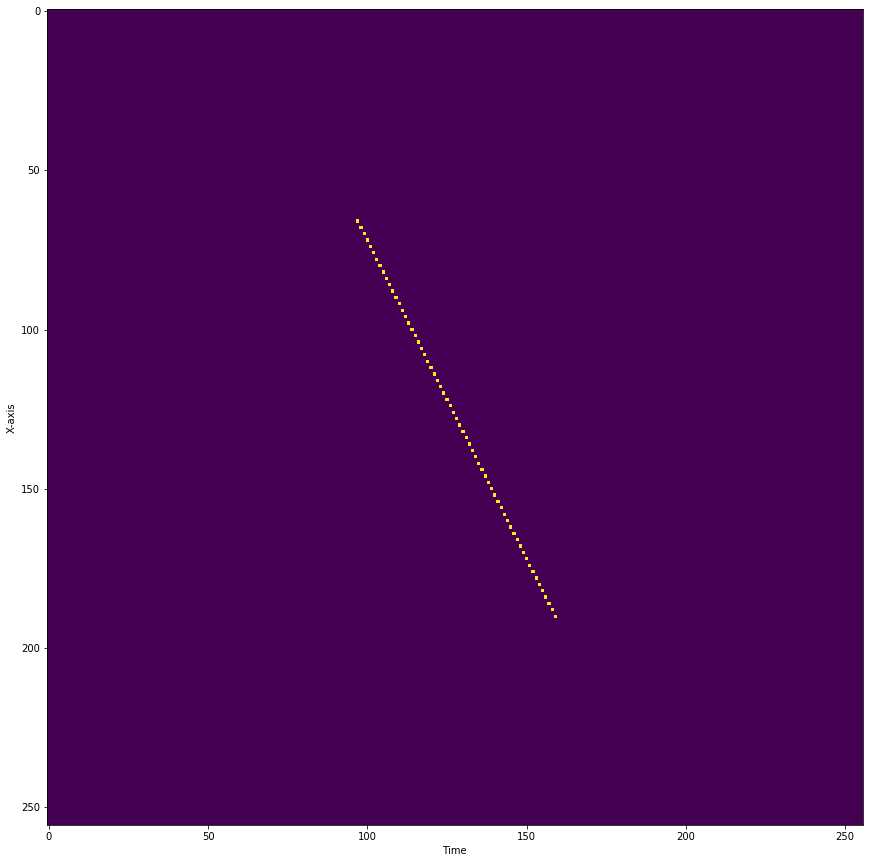

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(events.mean(axis=1))
ax.set_xlabel('Time')
ax.set_ylabel('X-axis');

In [7]:
mc1 = mc.envelope_gabor(fx, fy, ft, **opts)
mc.figures(mc1, name_, seed=seed, events=events, figpath=mc.figpath)
mc.in_show_video(name_, figpath=mc.figpath)

To replicate the work from Watamaniuk, McKee and colleagues, we replicate the same motion but where we keep the motion energy while shuffling the coherence:

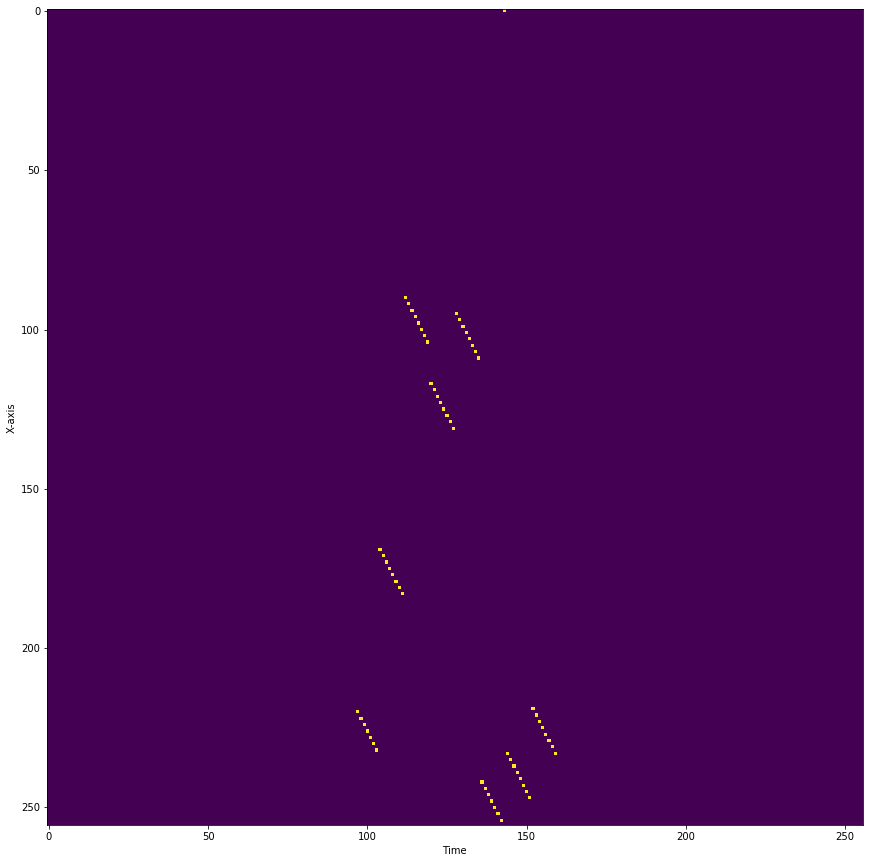

In [8]:
name_ = name + '_shuffled'
N_folds = 8
N_traj = int((t1-t0)*mc.N_frame) // N_folds
N_start = int(t0*mc.N_frame)
folding = np.random.permutation(N_folds)
events_shuffled = events.copy()
for i_fold in range(N_folds):
    S0, S1 = (N_start+folding[i_fold]*N_traj), (N_start+(folding[i_fold]+1)*N_traj)
    N0, N1 = (N_start+i_fold*N_traj), (N_start+(i_fold+1)*N_traj)
    nx = int(np.random.rand()*mc.N_Y)
    ny = int(np.random.rand()*mc.N_Y)
    events_shuffled[:, :, S0:S1] = np.roll(np.roll(events[:, :, N0:N1], nx, axis=0), ny, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(events_shuffled.mean(axis=1))
ax.set_xlabel('Time')
ax.set_ylabel('X-axis');

In [9]:
mc1 = mc.envelope_gabor(fx, fy, ft, **opts)
mc.figures(mc1, name_, seed=seed, events=events_shuffled, figpath=mc.figpath)
mc.in_show_video(name_, figpath=mc.figpath)

## addition of a the trajectory to the incoherent noise

It is now possible to add this trajectory to any kind of background, such as a background texture of the same "texton" but with a null average motion:

In [10]:
def overlay(movie1, movie2, rho, do_linear=False):
    if do_linear:
        return rho*movie1+(1-rho)*movie2
    else:
        movie1, movie2 = rho*(2.*movie1-1), 2.*movie2-1
        movie = np.zeros_like(movie1)
        mask = np.abs(movie1) > np.abs(movie2)
        movie[mask] = movie1[mask]
        movie[1-mask] = movie2[1-mask]
        return .5 + .5*movie

a more memory-efficient version of the above:

In [11]:
def overlay(movie1, movie2, rho, do_linear=False):
    if do_linear:
        return rho*movie1+(1-rho)*movie2
    else:
        movie1, movie2 = rho*(2.*movie1-1), 2.*movie2-1
        movie = movie1 * (np.abs(movie1) > np.abs(movie2)) + movie2 * (np.abs(movie1) <= np.abs(movie2))
        #return .5 + .5*movie
        return 1. * (movie > 0.)
        #seuil = .1
        #return .5 + .5 * (-1. * (movie < -seuil) +  1. * (movie > seuil))
        #return  .5 + .5* np.tan(4.*movie)

In [12]:
mc1 = mc.envelope_gabor(fx, fy, ft, **opts)
movie_coh = mc.rectif(mc.random_cloud(mc1, seed=seed, events=events))
opts_ = opts.copy()
opts_.update(V_X=0)
mc0 = mc.envelope_gabor(fx, fy, ft, **opts_)
movie_unc = mc.rectif(mc.random_cloud(mc0, seed=seed+1))

In [13]:
name_ = name + '_overlay'
rho_coh = .9
mc.anim_save(overlay(movie_coh, movie_unc, rho_coh), os.path.join(mc.figpath, name_))
mc.in_show_video(name_, figpath=mc.figpath)

""


In [14]:
name_ = name + '_overlay_difficult'
rho_coh = .5
mc.anim_save(overlay(movie_coh, movie_unc, rho_coh), os.path.join(mc.figpath, name_))
mc.in_show_video(name_, figpath=mc.figpath)

""


Though it is difficult to find the coherent pattern in a single frame, one detects it thanks to its coherent motion.

In [15]:
name_ = name + '_overlay_shuffled'
movie_coh_shuffled = mc.rectif(mc.random_cloud(mc1, seed=seed, events=events_shuffled))
rho_coh = .9
mc.anim_save(overlay(movie_coh_shuffled, movie_unc, rho_coh), os.path.join(mc.figpath, name_))
mc.in_show_video(name_, figpath=mc.figpath)

""


In [16]:
name_ = name + '_overlay_difficult_shuffled'
rho_coh = .5
mc.anim_save(overlay(movie_coh_shuffled, movie_unc, rho_coh), os.path.join(mc.figpath, name_))
mc.in_show_video(name_, figpath=mc.figpath)

""


## trying out different directions


In [17]:
name_ = name + '_overlay_difficult_reversed'
mc.anim_save(overlay(movie_coh[::-1, :, :], movie_unc, rho_coh), os.path.join(mc.figpath, name_))
mc.in_show_video(name_, figpath=mc.figpath)

""


In [18]:
name_ = name + '_overlay_difficult_shuffled_reversed'
mc.anim_save(overlay(movie_coh_shuffled[::-1, :, :], movie_unc, rho_coh), os.path.join(mc.figpath, name_))
mc.in_show_video(name_, figpath=mc.figpath)

""


## some book keeping for the notebook

In [20]:
%load_ext watermark
%watermark

2020-01-14T11:23:54+01:00

CPython 3.7.6
IPython 7.11.1

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit


In [21]:
%load_ext watermark
%watermark -i -h -m -v -p MotionClouds,numpy,pillow,imageio  -r -g -b

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-01-14T11:23:55+01:00

CPython 3.7.6
IPython 7.11.1

MotionClouds 20180606
numpy 1.19.0.dev0+624d34c
pillow not installed
imageio 2.6.1

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit
host name  : fortytwo
Git hash   : 7a9632c08197e479802f7b890ae18179d347a12e
Git repo   : https://github.com/laurentperrinet/sciblog.git
Git branch : master
